# CNN오토인코더 균열탐지

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2 as cv
import sklearn
from sklearn.model_selection import train_test_split

정상 이미지와 균열 이미지를 불러옵니다.

In [4]:
#정상 이미지를 1로 균열 이미지를 0으로 label합니다.
src = './crack/Negative_pro/'
def img_read(src, file):
    img = cv.imread(src+file)
    img = cv.resize(img,(128, 128))
    return img
files = os.listdir(src)
X = []
Y = []
for file in files:
    X.append(img_read(src,file)/255.)#정규화
    Y.append(1) 

X = np.array(X)
Y = np.array(Y)
#학습데이터 80% 테스트 데이터 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle='True')

print('train shape: ', X_train.shape)
print('test shape: ', X_test.shape)

train shape:  (2400, 128, 128, 3)
test shape:  (600, 128, 128, 3)


In [5]:
src = './crack/positive_pro/'
def img_read(src,file):
    img = cv.imread(src+file)
    img = cv.resize(img, (128, 128))
    return img
files = os.listdir(src)

Anomaly = []
Anomaly_Y = []
for file in files: 
    Anomaly.append(img_read(src,file)/255.)
    Anomaly_Y.append(0) #label 0

Anomaly = np.array(Anomaly)
Anomaly_Y = np.array(Anomaly_Y)
print('Anomaly shape:', np.shape(Anomaly))
print('Anomaly_y shape:', np.shape(Anomaly_Y))

Anomaly shape: (1000, 128, 128, 3)
Anomaly_y shape: (1000,)


CNN-AutoEncoder 모델을 생성합니다.

In [6]:
#HyperParameter
Size = 128
batch_size = 64

#모델
input = layers.Input(shape=(Size, Size, 3))
# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=['mse'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624  

In [7]:
#학습
history = autoencoder.fit(
        X_train, X_train,
        batch_size= batch_size,
        epochs=200,
        validation_data=(X_test, X_test),
        shuffle = True)

Epoch 1/200
38/38 [==============================] - 13s 167ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2/200
38/38 [==============================] - 5s 125ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 3/200
38/38 [==============================] - 5s 123ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/200
38/38 [==============================] - 5s 124ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/200
38/38 [==============================] - 5s 124ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/200
38/38 [==============================] - 5s 122ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/200
38/38 [==============================] - 4s 118ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/200
38/38 [==============================] - 5s 121ms/step -

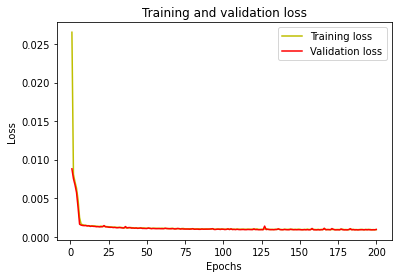

In [8]:
#학습 결과 확인
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

테스트 데이터로 cost를 구해봅니다.

In [9]:
test_score = autoencoder.evaluate(X_test, X_test, verbose=0)
print('Normal Testing data cost = ', '{:.4f}'.format(test_score[0]))

Normal Testing data cost =  0.0009


정상이미지 input 이미지와 오토인코더 output 복원 사진

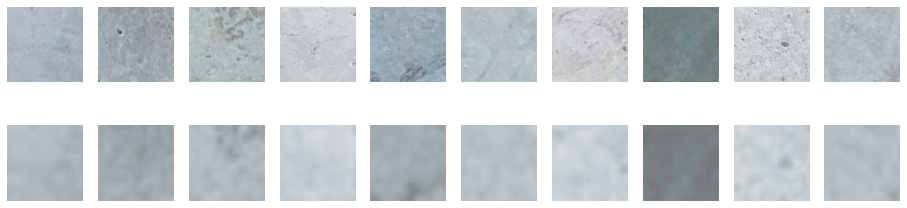

In [10]:
sample_size = 10                        
predicted = autoencoder.predict(X_test)  #테스트 데이터로 복원  

fig, ax = plt.subplots(2, sample_size, figsize=(16, 4))
for i in range(sample_size):
  org_img1 = X_test[i]
  rec_img1 = predicted[i]
  
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
  ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
plt.show()

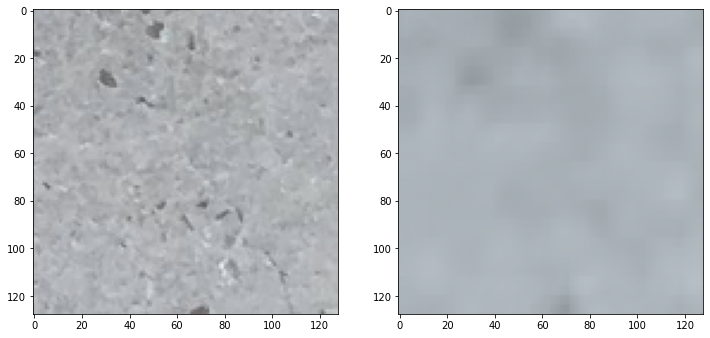

In [98]:
#크게 비교
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number]) 
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [24]:
#anomaly loss값 확인
Anomaly_score = autoencoder.evaluate(Anomaly, Anomaly, verbose=0)
print('Abnormal Testing data cost = ', '{:.4f}'.format(Anomaly_score[0]))

Abnormal Testing data cost =  0.0058


균열 사진 복원 비교

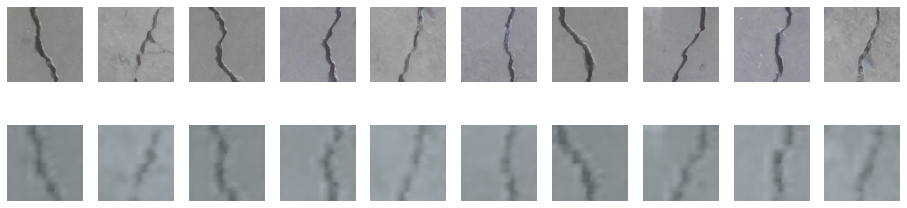

In [25]:
sample_size = 10                        
predicted2 = autoencoder.predict(Anomaly) 
# plot 하기
fig, ax = plt.subplots(2, sample_size, figsize=(16, 4))
for i in range(sample_size):
  org_img2 = Anomaly[i]
  rec_img2 = predicted2[i]
  
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  
  ax[0][i].imshow(org_img2, cmap=plt.cm.bone)
  ax[1][i].imshow(rec_img2, cmap=plt.cm.bone)

plt.show()

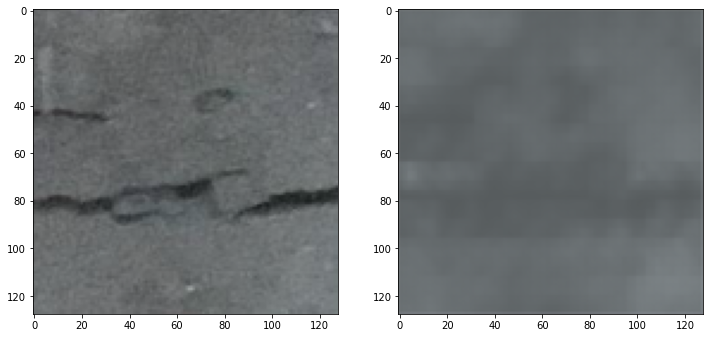

In [68]:
#크게 비교
image_number = random.randint(0, predicted2.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(Anomaly[image_number]) 
plt.subplot(122)
plt.imshow(predicted2[image_number])
plt.show()

정상이미지와 균열이미지의 MSE분포도 확인

In [27]:
import pandas as pd
nom_data = np.concatenate((X_test, X_train), axis=0)
nom_pred = autoencoder.predict(nom_data) #AE이미지 결과값

nom_data_reshaped = nom_data.reshape((len(nom_data), np.prod(nom_data.shape[1:])))
nom_pred_reshaped = nom_pred.reshape((len(nom_pred), np.prod(nom_pred.shape[1:])))

nom_pred_mse = np.mean(np.power(nom_data_reshaped - nom_pred_reshaped, 2), axis=1) #MSE
nom_pred_mse_df = pd.DataFrame({'normal_mse': nom_pred_mse})
print(nom_pred_mse_df.describe())

        normal_mse
count  3000.000000
mean      0.000968
std       0.000716
min       0.000137
25%       0.000543
50%       0.000781
75%       0.001154
max       0.015772


In [28]:
Anom_pred = autoencoder.predict(Anomaly)

ANom_reshape = Anomaly.reshape((len(Anomaly), np.prod(Anomaly.shape[1:])))
Anom_pred_reshape = Anom_pred.reshape((len(Anom_pred), np.prod(Anom_pred.shape[1:])))

Anom_pred_mse = np.mean(np.power(ANom_reshape - Anom_pred_reshape, 2), axis=1)
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':Anom_pred_mse})
print(ANom_pred_mse_df.describe())

       Anomaly_mse
count  1000.000000
mean      0.005750
std       0.002371
min       0.001027
25%       0.003983
50%       0.005795
75%       0.007366
max       0.013686


정상 이미지와 균열 이미지의 MSE의 히스토그램

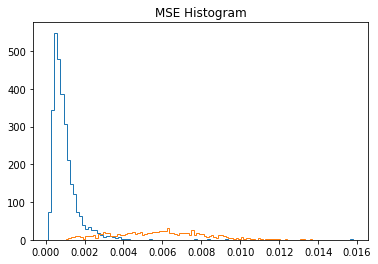

In [34]:
plt.figure()
plt.title('MSE Histogram')
plt.hist(nom_pred_mse, bins = 100, facecolor = 'blue', histtype='step')
plt.hist(Anom_pred_mse, bins= 100, facecolor= 'red', histtype='step') 
plt.show()

데이터 설정 (normal train 중 20%의 x_test + 균열anomaly 1000 image)

In [99]:
test_data = np.concatenate((X_test, Anomaly), axis = 0)
y_true = np.concatenate((Y_test, Anomaly_Y), axis= 0)
print(test_data.shape, y_true.shape)

(1600, 128, 128, 3) (1600,)


![nn](autoencoder.jpg)

정상 input 이미지와 오토인코더의 output 이미지의 MSE를 구하고 균열 이미지 또한 MSE를 구한 후 정상과 균열의 MSE 차이를 적정한

임계값(threshold)을 설정하고 임계값을 기준으로 정상과 균열에 label합니다.

In [101]:
test_data_pred = autoencoder.predict(test_data)

test_data_shaped = test_data.reshape((len(test_data), np.prod(test_data.shape[1:])))
test_data_pred_shaped = test_data_pred.reshape((len(test_data_pred), np.prod(test_data_pred.shape[1:])))

all_cost = np.mean(np.power(test_data_shaped - test_data_pred_shaped, 2), axis=1)

In [102]:
#임계값 설정
threshold = 0.0025

y_pred = []
for i in range(len(all_cost)):
    if all_cost[i] > threshold:
        y_pred.insert(i, 0) #positive
    else:
        y_pred.insert(i, 1) #negative

print(y_pred[100:500])    
print(np.shape(y_pred))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

평가하기

In [103]:
#혼돈 행렬
from sklearn.metrics import confusion_matrix

con_mat = confusion_matrix(y_true, y_pred)

TP = con_mat[0][0]
FN = con_mat[0][1]
FP = con_mat[1][0]
TN = con_mat[1][1]
print('\n',
      'TP :', TP, '\n', 
      'FN :', FN, '\n', 
      'FP :', FP, '\n', 
      'TN :', TN, '\n')
Accuracy = (TP+TN)/(TP+FN+FP+TN)
Error_rate = (FP+FN) /(TP+FN+FP+TN) 
Precision = TP / (TP+FP)
Recall = TP /(TP+FN)

print('Accuracy:', '{:.2%}'.format(Accuracy))
print('Error_rate:', '{:.2%}'.format(Error_rate))
print('Precision:', '{:.2%}'.format(Precision))
print('Recall:', '{:.2%}'.format(Recall))
print("f1-Score: {}".format(2/ ((1 / Precision) + (1 / Recall))))


 TP : 909 
 FN : 91 
 FP : 19 
 TN : 581 

Accuracy: 93.12%
Error_rate: 6.88%
Precision: 97.95%
Recall: 90.90%
f1-Score: 0.9429460580912863


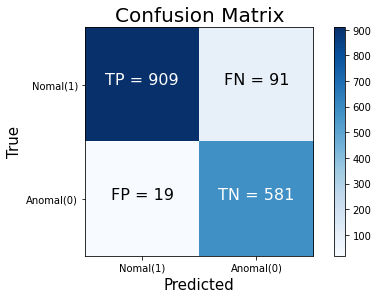

In [105]:
plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=20) 
plt.tight_layout()
plt.colorbar()
label=["Nomal(1)", "Anomal(0)"] 
tick_marks = np.arange(len(label)) 
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)

name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(2):
     for j in range(2):
        plt.text(j, i, str(name[i][j])+" = "+str(con_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black",
                 fontsize=16)
plt.show()